In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def display(img,title=''):
    plt.figure(figsize=(5,5))
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
img = cv2.imread('./img/barcode1.png')
processed_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
processed_img=cv2.GaussianBlur(processed_img,ksize=(5,5),sigmaX=5/2*np.pi,sigmaY=5/2*np.pi)
processed_img = cv2.Laplacian(processed_img, ddepth=cv2.CV_64F, ksize=5)
display(processed_img)

In [57]:
# image = cv2.imread('./img/barcode1.png')
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # compute the Scharr gradient magnitude representation of the images
# # in both the x and y direction using OpenCV 2.4
# gradX = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
# gradY = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

# # subtract the y-gradient from the x-gradient
# gradient = cv2.subtract(gradX, gradY)
# gradient = cv2.convertScaleAbs(gradient)

# # blur and threshold the image
# blurred = cv2.blur(gradient, (9, 9))
# (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
# closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# # perform a series of erosions and dilations
# closed = cv2.erode(closed, None, iterations = 4)
# closed = cv2.dilate(closed, None, iterations = 4)

# # find the contours in the thresholded image, then sort the contours
# # by their area, keeping only the largest one
# cnts,_ = cv2.findContours(closed.copy().astype(np.uint8), cv2.RETR_EXTERNAL,
# 	cv2.CHAIN_APPROX_SIMPLE)
# c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]

# # compute the rotated bounding box of the largest contour
# rect = cv2.minAreaRect(c)
# box =  cv2.boxPoints(rect)
# box = np.int0(box)

# # draw a bounding box arounded the detected barcode and display the
# # image
# cv2.drawContours(image, [box], -1, (0, 255, 0), 3)
# display(image)


In [136]:
def getBarcodeAngle(img,debug=False):
    fft=np.fft.fftshift(np.fft.fft2(img))
    fft_img=(20*np.log(abs(fft))).astype(np.uint8)

    gauss_blurred=cv2.GaussianBlur(fft_img,(5,5),sigmaX=5,sigmaY=5)
    laplacian=cv2.Laplacian(gauss_blurred,ddepth=cv2.CV_8U,ksize=5)

    blurred=cv2.blur(fft_img+np.maximum(-laplacian,0),(9,9))
    _,thresh=cv2.threshold(blurred,180,255,cv2.THRESH_BINARY)
    display(thresh)
    h,w=thresh.shape
    thresh_1=thresh[int(h/2*0.3):int(h/2*1),int(w/2*0.3):int(w/2*1)]
    thresh_2=thresh[int(h/2*0.3):int(h/2*1),w-int(w/2*1):w-int(w/2*0.3)]
    ker1=np.array([
        [1,1,1,0,0],
        [1,1,1,0,0],
        [1,1,0,0,0],
        [0,0,0,0,0],
        [0,0,0,0,0]
    ]).astype(np.uint8)
    ker2=np.array([
        [0,0,1,1,1],
        [0,0,1,1,1],
        [0,0,0,1,1],
        [0,0,0,0,0],
        [0,0,0,0,0]
    ]).astype(np.uint8)
    thresh_1=cv2.dilate(thresh_1,ker1,iterations=2)
    thresh_1=cv2.erode(thresh_1,None,iterations=2)

    thresh_2=cv2.dilate(thresh_2,ker2,iterations=2)
    thresh_2=cv2.erode(thresh_2,None,iterations=2)

    thresh[int(h/2*0.3):int(h/2*1),int(w/2*0.3):int(w/2*1)]=thresh_1
    thresh[int(h/2*0.3):int(h/2*1),w-int(w/2*1):w-int(w/2*0.3)]=thresh_2

    count1=0
    count2=0
    len1=0
    len2=0
    angle=0
    angle1=0
    angle2=0
    count=0
    raylen=0
    for i in range(int(h/2*0.3),int(h/2*0.99)):
        for j in range(int(w/2*0.3),int(w/2*0.99)):
            dx=w//2-j
            dy=h//2-i
            len1+=thresh[i,j]/255.0*np.sqrt(dx*dx+dy*dy)
            angle1=angle1+thresh[i,j]/255*np.arctan(dy/dx)
            count1=count1+thresh[i,j]/255
    for i in range(int(h/2*0.3),int(h/2*0.99)):
        for j in range(w-int(w/2*0.99),w-int(w/2*0.3)):
            dx=j-w//2
            dy=h//2-i
            len2+=thresh[i,j]/255.0*np.sqrt(dx*dx+dy*dy)
            angle2=angle2+thresh[i,j]/255*np.arctan(dy/dx)
            count2=count2+thresh[i,j]/255
    if count1>count2:
        angle=angle1
        count=count1
        raylen=len1
    else:
        angle=-angle2
        count=count2
        raylen=len2
    angle=angle/count/np.pi*180
    raylen=raylen/count
    if angle>45:
        angle=90-angle
    if raylen < min(w,h)*0.1:
        angle=0
    return angle
image1 = cv2.imread('./img/barcode1.png')
image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# angle=getBarcodeAngle(image)
# angle



In [ ]:
def rotateImg(img,angle,debug=False):
    h,w=img.shape
    center=w/2,h/2
    rotate_matrix=cv2.getRotationMatrix2D(center=center,angle=angle,scale=1)
    rotated_image=cv2.warpAffine(src=img,M=rotate_matrix,dsize=(w,h))
    display(rotated_image)
    return rotated_image

rotated_image=rotateImg(image,angle,True)

In [6]:
def getImgMask(rotated_image,debug=False):
    gradX=cv2.Sobel(rotated_image,ddepth=cv2.CV_32F,dx=1, dy=0, ksize=-1)
    gradY=cv2.Sobel(rotated_image,ddepth=cv2.CV_32F,dx=0, dy=1, ksize=-1)
    
    # By performing this subtraction we are left with regions of the image 
    #that have high horizontal gradients and low vertical gradients.
    gradient=abs(gradX)-abs(gradY)
    gradient=np.maximum(gradient,0)
    # display(gradient)
    blurred = cv2.blur(gradient, (9, 9))
    hist, _ = np.histogram(blurred.flatten(),
                          bins=256,
                          range=[0,255])
    threshold=np.median(hist)
    closest=min(hist,key= lambda x: abs(x-threshold))
    index = np.where(hist == closest)[0][0]

    (_, thresh) = cv2.threshold(blurred, index, 255, cv2.THRESH_BINARY)
    # display(thresh)
    # construct a closing kernel and apply it to the thresholded image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # perform a series of erosions and dilations
    closed = cv2.erode(closed, None, iterations = 15)
    closed = cv2.dilate(closed, None, iterations = 15)
    # display(closed)
    return closed
# msk=getImgMask(image)

In [87]:
# msk=rotateImg(msk,-angle,True)

In [13]:
def drawBarCodeBoundary(raw_img,msk):
    cnts,_ = cv2.findContours(msk.copy().astype(np.uint8), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return raw_img
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # (x,y),(width,height),angle=cv2.minAreaRect(c)
    # print(width,height)
    # x,y=int(x),int(y)
    # print(x,y)
    # points=np.array([
    #     [-width/2,-height/2],
    #     [width/2,-height/2],
    #     [width/2,height/2],
    #     [-width/2,height/2]
    # ])
    # c,s=np.cos(angle*np.pi/180),np.sin(angle*np.pi/180)
    # rotate_matrix=np.array(((c,-s),(s,c)))
    # points=np.transpose(np.matmul(rotate_matrix,np.transpose(points)))
    # for i in range(0,len(points)-1):
    #     x1=int(points[i][0])
    #     y1=int(points[i][1])
    #     x2=int(points[i+1][0])
    #     y2=int(points[i+1][1])
    #     cv2.line(raw_img,(x+x1,y+y1),(x+x2,y+y2),color=(0,255,0),thickness=5)
    
    rect=cv2.minAreaRect(c)
    box =  cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(raw_img, [box], -1, (0, 255, 0), 3)
    return raw_img
# raw_img=drawBarCodeBoundary(image1,msk)
# display(raw_img)

In [14]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    suc, img = cap.read()
    img1=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    msk=getImgMask(img1)
    
    raw_img=drawBarCodeBoundary(img,msk)
    cv2.imshow("Frame", raw_img)
    if cv2.waitKey(5) & 0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()

# That technique has to depend on threshold to thresh color → Not completed

In [ ]:
card_img=cv2.imread('./img/card.png')
K=11
card_img_blurred=cv2.GaussianBlur(card_img,ksize=(K,K),sigmaX=K/(2*np.pi),sigmaY=K/(2*np.pi))

image_hsv=cv2.cvtColor(card_img_blurred,cv2.COLOR_BGR2HSV)
_,thresh_h=cv2.threshold(image_hsv[:,:,0],70,179,cv2.THRESH_BINARY)
_,thresh_s=cv2.threshold(image_hsv[:,:,1],150,255,cv2.THRESH_BINARY)
_,thresh_v=cv2.threshold(image_hsv[:,:,2],100,255,cv2.THRESH_BINARY)
bitWiseAnd=cv2.bitwise_and(thresh_h,thresh_s)
bitWiseAnd=cv2.bitwise_and(bitWiseAnd,thresh_v)

# image_gray=cv2.cvtColor(card_img_blurred,cv2.COLOR_BGR2GRAY)
# #Autocanny
sigma = 1
median = np.median(image_hsv[:,:,2]*bitWiseAnd)

# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * median))
upper = int(min(255, (1.0 + sigma) * median))
edge_hsv = cv2.Canny(image_hsv[:,:,2]*bitWiseAnd,lower,upper,apertureSize=3 ,L2gradient=True)
# edge_hsv = cv2.Canny(image_gray,lower,upper,apertureSize=3 ,L2gradient=True)
display(edge_hsv)
edge_hsv=cv2.bilateralFilter(edge_hsv, 15, 75, 75) 
edge_hsv=cv2.Laplacian(edge_hsv,cv2.CV_64F,ksize=7)

edge_hsv=np.maximum(-edge_hsv,0)
edge_hsv=np.minimum(edge_hsv,255)
display(edge_hsv)
contours,hierarchy=cv2.findContours(edge_hsv.astype(np.uint8),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
image_copy=card_img.copy()
from random import randint
cnt=-2
cntPerimeter=0

for i in range(len(contours)):
    if hierarchy[0][i][3]==-1:
        perimeter=cv2.arcLength(contours[i],True)
        if cntPerimeter < perimeter:
            cntPerimeter=perimeter
            cnt=i
cv2.drawContours(image_copy,contours,cnt,(0,255,0),2,cv2.LINE_AA)
display(image_copy)
len(contours)

# # display(canny_img)
# cnts,_ = cv2.findContours(canny_img.copy().astype(np.uint8), cv2.RETR_EXTERNAL,
# 	cv2.CHAIN_APPROX_SIMPLE)
# c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# rect=cv2.minAreaRect(c)
# box =  cv2.boxPoints(rect)
# box = np.int0(box)
# cv2.drawContours(card_img, [box], -1, (0, 255, 0), 3)
# display(card_img)

# Using Hough transform 

*** NOT COMPLETED

[51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49
 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49 49
 49 49 49 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48
 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48 48
 48 48 48 48 48 48 48 48 48 48 48 48 47 47 47]
47
154
27


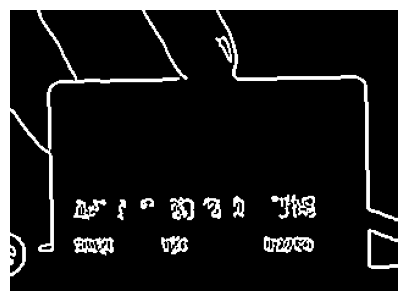

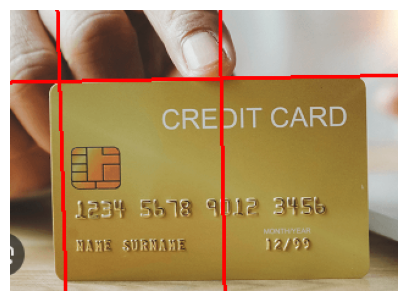

In [357]:
card_img=cv2.imread('./img/card4.png')
K=5
card_img_blurred=cv2.GaussianBlur(card_img,ksize=(K,K),sigmaX=K/(2*np.pi),sigmaY=K/(2*np.pi))
image_gray=cv2.cvtColor(card_img_blurred,cv2.COLOR_BGR2GRAY)
sigma = 1
median = np.median(image_gray)

# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * median))
upper = int(min(255, (1.0 + sigma) * median))
edge_hsv = cv2.Canny(image_gray,lower,upper,apertureSize=3 ,L2gradient=True)
edge_hsv=cv2.bilateralFilter(edge_hsv, 15, 75, 75) 
edge_hsv=cv2.Laplacian(edge_hsv,cv2.CV_64F,ksize=7)
edge_hsv=np.maximum(-edge_hsv,0)
edge_hsv=np.minimum(edge_hsv,255)
# display(edge_hsv)
lines = cv2.HoughLines(edge_hsv.astype(np.uint8), 1, np.pi/180, 10)

contours,hierarchy=cv2.findContours(edge_hsv.astype(np.uint8),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
image_copy=card_img.copy()
from random import randint
cnt=-2
cntPerimeter=0

for i in range(len(contours)):
    if hierarchy[0][i][3]==-1:
        perimeter=cv2.arcLength(contours[i],True)
        if cntPerimeter < perimeter:
            cntPerimeter=perimeter
            cnt=i
# cv2.drawContours(image_copy,contours,cnt,(0,255,0),2,cv2.LINE_AA)
arr = np.array(lines[0][0], dtype=np.float64)
r, theta = arr
a = np.cos(theta)
b = np.sin(theta)
x0 = a*r
y0 = b*r
x1_b = int(x0 + 1000*(-b))
y1_b = int(y0 + 1000*(a))
x2_b = int(x0 - 1000*(-b))
y2_b = int(y0 - 1000*(a))
# x1_b,y1_b,x2_b,y2_b=lines[0][0]
vectorx_b=x1_b-x2_b
vectory_b=y1_b-y2_b
a_base=(y1_b-y2_b)/(x1_b-x2_b)
b_base=y1_b-a_base*x1_b
edge_points=[]
for i in range(contours[cnt].shape[0]):
    if -1<np.floor(contours[cnt][i,0,1]-a_base*contours[cnt][i,0,0]-b_base) <1:
        edge_points.append((contours[cnt][i,0,0],contours[cnt][i,0,1],i))
cv2.line(card_img, (x1_b, y1_b), (x2_b, y2_b), (0, 0, 255), 2)
two_lines=[]
for point in lines[1:]:
    arr = np.array(point[0], dtype=np.float64)
    r, theta = arr
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    # x1,y1,x2,y2=point[0]
    vectorx=x1-x2
    vectory=y1-y2
    temp= np.abs(vectorx_b*vectorx+vectory*vectory_b)/(np.sqrt(vectorx**2+vectory**2)*np.sqrt(vectorx_b**2+vectory_b**2))
    if temp>1:
        temp=np.floor(temp)
    angle=np.arccos(temp)
    angle=180*angle/np.pi
    if 89<angle<91 and x1-x2!=0:
        a=(y1-y2)/(x1-x2)
        b=y1-a*x1
        closest_x=min(edge_points,key= lambda x: np.abs(x[1]-a*x[0]-b)/np.sqrt(a**2+b**2))
        if -1 <np.abs(closest_x[1]-a*closest_x[0]-b)/np.sqrt(a**2+b**2)<1:
            two_lines.append([[x1,y1],[x2,y2],closest_x[2]])
two_lines = sorted(two_lines, key = lambda x: x[2])
x1=two_lines[0][0][0]
y1=two_lines[0][0][1]
x2=two_lines[0][1][0]
y2=two_lines[0][1][1]
a=(y1-y2)/(x1-x2)
b=y1-a*x1
x_intersec=int((b_base-b)/(a-a_base))
y_intersec=np.abs(int(a*x_intersec+b))
y_array=[]
for i in range(edge_hsv.shape[0]):
    y_array.append(y_intersec-i)
y_array=np.array(y_array).astype(int)
x_array=np.array(np.floor(((y_array-b)/a)).astype(int))
print(x_array)
# print(y_array)
minx=min(x_array)
print(minx)
points_array=np.array(list(zip(x_array, y_array)))
best_idx=0
best_count=0
_,edge_hsv=cv2.threshold(edge_hsv,1,255,cv2.THRESH_BINARY)
oneminus=np.ones_like(x_array,dtype=int)
for i in range(1,minx):
    count=0
    for j in range(edge_hsv.shape[0]):
        # edge_hsv[points_array[j][1],points_array[j][0]-15]=255
        temp_matrix=np.array([
            [edge_hsv[points_array[j][1]-1,points_array[j][0]-4],edge_hsv[points_array[j][1]-1,points_array[j][0]-3],edge_hsv[points_array[j][1]-1,points_array[j][0]-2],edge_hsv[points_array[j][1]-1,points_array[j][0]-1],edge_hsv[points_array[j][1]-1,points_array[j][0]],edge_hsv[points_array[j][1]-1,points_array[j][0]+1],edge_hsv[points_array[j][1]-1,points_array[j][0]+2]],
            [edge_hsv[points_array[j][1],points_array[j][0]-4],edge_hsv[points_array[j][1],points_array[j][0]-3],edge_hsv[points_array[j][1],points_array[j][0]-2],edge_hsv[points_array[j][1],points_array[j][0]-1],edge_hsv[points_array[j][1],points_array[j][0]],edge_hsv[points_array[j][1],points_array[j][0]+1],edge_hsv[points_array[j][1],points_array[j][0]+2]],
            [edge_hsv[points_array[j][1]+1,points_array[j][0]-4],edge_hsv[points_array[j][1]+1,points_array[j][0]-3],edge_hsv[points_array[j][1]+1,points_array[j][0]-2],edge_hsv[points_array[j][1]+1,points_array[j][0]-1],edge_hsv[points_array[j][1]+1,points_array[j][0]],edge_hsv[points_array[j][1]+1,points_array[j][0]+1],edge_hsv[points_array[j][1]+1,points_array[j][0]+2]],
        ])
        if np.any(temp_matrix == 255):
            count+=1
    x_array=x_array-oneminus
    points_array=np.array(list(zip(x_array, y_array)))
    if best_count<count:
        best_count=count
        best_idx=i+10
print(best_count)
print(best_idx)
cv2.line(card_img, (two_lines[0][0][0]-best_idx,two_lines[0][0][1]-best_idx), two_lines[0][1], (0, 0, 255), 2)
cv2.line(card_img, two_lines[len(two_lines)-1][0], two_lines[len(two_lines)-1][1], (0, 0, 255), 2)
# vectorx_p=two_lines[0][0][0]-two_lines[0][1][0]
# vectory_p=two_lines[0][0][1]-two_lines[0][1][1]
# one_line=[]
# for point in lines[1:]:
#     arr = np.array(point[0], dtype=np.float64)
#     r, theta = arr
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*r
#     y0 = b*r
#     x1 = int(x0 + 1000*(-b))
#     y1 = int(y0 + 1000*(a))
#     x2 = int(x0 - 1000*(-b))
#     y2 = int(y0 - 1000*(a))
#     # x1,y1,x2,y2=point[0]
#     vectorx=x1-x2
#     vectory=y1-y2
#     temp= np.abs(vectorx_p*vectorx+vectory*vectory_p)/(np.sqrt(vectorx**2+vectory**2)*np.sqrt(vectorx_p**2+vectory_p**2))
#     if temp>1:
#         temp=np.floor(temp)
#     angle=np.arccos(temp)
#     angle=180*angle/np.pi
#     if 89<angle<91 and x1-x2!=0:
#         a=(y1-y2)/(x1-x2)
#         b=y1-a*x1
#         closest_x=min(edge_points,key= lambda x: np.abs(x[1]-a*x[0]-b)/np.sqrt(a**2+b**2))
#         if -1 <np.abs(closest_x[1]-a*closest_x[0]-b)/np.sqrt(a**2+b**2)<1:
#             one_line.append([(x1,y1),(x2,y2),closest_x[2]])
# one_line = sorted(one_line, key = lambda x: np.abs(x[0][1]-a_base*x[0][0]-b_base)/np.sqrt(a_base**2+b_base**2),reverse=True)

# cv2.line(card_img, one_line[0][0], one_line[0][1], (0, 0, 255), 2)
card_img=cv2.cvtColor(card_img,cv2.COLOR_BGR2RGB)
display(edge_hsv)
display(card_img)
# len(contours)

In [312]:
x_array=np.array([3,4,5,67])
x_array-np.ones_like(x_array,dtype=int)

array([ 2,  3,  4, 66])